# DSCI 100 Group Project Report: The relationship between various socioeconomic factors and life expectancy at birth
##### Group 141: Matilde Galantino, Jacob Guglielmin, Phoenix Jin, Amy Wong 

## Introduction
### Background 

Life expectancy, a measurement of the mean age of death in a population, is a crucial metric in assessing the wellbeing of populations, and as such, is of pertinence in both medical and socioeconomic research. Life expectancy has risen drastically in industrialized countries since the 19th century due to improvements in technology and healthcare, from 66.8 years in 2000 to 73.4 years in 2019 (World Health Organization, 2019). However, this increase is not truly equal - countries with lower human development have consistently reported lower life expectancies, leading to a large discrepancy in health worldwide (Roser et al., 2013). It is therefore important to determine what impedes or enhances the life expectancy of a population in order to improve societal conditions around the world.

### Question 

How do CO<sub>2</sub> emissions per capita, mean years of schooling, gross national income, and poverty rate affect life expectancy for both less developed and more developed countries, and how can less developed countries use this information to increase their life expectancy?

### Dataset 

We will use two datasets from the United Nations Development Programme and the World Bank; the one from the United Nations Development Programme contains data on CO<sub>2</sub> emissions per capita, mean years of schooling, gross national income, and life expectancy at birth by country and year, and the dataset from the World Bank contains data on poverty rate by country and year.

## Expected outcomes: 
We expect to find relationships between all four of our selected socioeconomic factors and life expectancy at birth. 

1. CO<sub>2</sub> concentrations have increased in the atmosphere over time due to human activity. Several decades of research have indicated that rising air pollution threatens local ecosystems and human health (Balakrishnan et al., 2018). As such, we expect to find a negative relationship between CO<sub>2</sub> emissions and life expectancy.

2. Education has an important role in shaping society, and so will be investigated for contributions to life expectancy. Past research has indicated that higher levels of schooling lead to higher life expectancies due to more informed decisions and healthier lifestyles (Blackburn and Cipriani, 2002). Therefore, we expect to see a positive relationship between mean years of schooling and life expectancy.

3. The gross national income represents the total financial output of a country. At a national level, a higher GNI allows more spending for public systems such as improved healthcare and sanitation. Therefore, we expect a positive relationship between GNI and life expectancy. 

4. Lastly, the poverty rate represents the percentage of the country's population who has less than $6.85 to spend per day, in 2017 PPP dollars. Financial poverty very often leads to social effects such as poor living conditions and limited access to housing or healthcare. We expect a negative relationship between poverty ratio and life expectancy at birth.


## Methods: 
1. We will combine the two datasets that we selected. 

2. We will use the columns for the four variables as predictors, which are carbon dioxide emissions per capita, mean years of schooling, gross national income per capita, poverty rate, to predict life expectancy at birth

3. We will combine countries with 'Very High' and 'High' human development indices into a 'More Developed' category, and combine countries with 'Medium' and 'Low' indices into a 'Less Developed' category.

4. We will perform a multivariable regression with our four factors in order to predict life expectancy at birth.

5. We will use four scatterplots to visualize our results for each of our factors with their regression lines overlaid on their respective plots. We will also create a table displaying the RMSPE of each of our regressions, to compare the predictive power of each more easily.

##### **Run the following cell before continuing further - set** `need_install = TRUE` **if any of tidyverse, tidymodels, or cowplot are not installed on your system:**

In [20]:
need_install = FALSE

if (need_install) install.packages(c("tidyverse", "tidymodels", "cowplot"))

# Import libraries
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

### Read datasets from the web:

##### We are reading these data from GitHub, as we downloaded the data manually and uploaded the data we require since much of the data came packaged in a .zip file rather than available as a raw .csv. In addition, we can ensure that these links remain available, unlike the links of the original publishers.

In [2]:
# Download data - (data orginally from United Nations Development Programme) 
hdi_composite_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/hdr_composite_index.csv", show_col_types = FALSE)

hdi_composite_data_raw

iso3,country,hdicode,region,hdi_rank_2021,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,⋯,mf_2012,mf_2013,mf_2014,mf_2015,mf_2016,mf_2017,mf_2018,mf_2019,mf_2020,mf_2021
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,Low,SA,180,0.273,0.279,0.287,0.297,0.292,⋯,1.86,1.88,1.66,1.62,1.66,1.41,1.32,1.38,1.38,1.38
AGO,Angola,Medium,SSA,148,NA,NA,NA,NA,NA,⋯,4.09,4.53,3.97,3.59,2.79,2.64,2.28,2.18,2.18,2.18
ALB,Albania,High,ECA,67,0.647,0.629,0.614,0.617,0.624,⋯,12.44,11.49,13.14,12.61,14.39,14.46,12.85,12.96,12.96,12.96
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZAF,South Africa,High,SSA,109,0.632,0.641,0.647,0.652,0.658,⋯,9.55,10.09,8.41,8.06,7.55,7.76,7.60,7.55,7.55,7.55
ZMB,Zambia,Medium,SSA,154,0.412,0.408,0.408,0.414,0.411,⋯,4.74,4.68,3.92,3.36,3.12,3.21,2.80,2.38,2.38,2.38
ZWE,Zimbabwe,Medium,SSA,146,0.509,0.512,0.498,0.491,0.486,⋯,3.13,2.86,3.03,2.66,2.29,2.26,2.05,1.21,1.21,1.21


In [3]:
# Download data - (data orginally from World Bank) 
poverty_rate_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/poverty_rate.csv", skip = 4, show_col_types = FALSE)

poverty_rate_data_raw

country_name,country_code,development,indicator_name,indicator_code,1960,1961,1962,1963,1964,⋯,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aruba,ABW,NA,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Afghanistan,AFG,Low,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Angola,AGO,Medium,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,78,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
South Africa,ZAF,High,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,61.6,NA,NA,NA,NA,NA,NA,NA
Zambia,ZMB,Medium,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,90.7,NA,NA,NA,NA,NA,NA
Zimbabwe,ZWE,Medium,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,84.1,NA,85,NA,NA


### Clean and wrangle data into a tidy format:

In [4]:
# Tidy poverty rate data
poverty_rate_data <- poverty_rate_data_raw
poverty_rate_data <- poverty_rate_data |>
    select(-country_name, -indicator_name, -indicator_code, -development) |>
    pivot_longer(c(-country_code), names_to = "year", values_to = "poverty_rate") |>
    filter(!is.na(poverty_rate))

# Tidy HDI data
# Eliminate irrelevant columns
hdi_composite_data_relevant <- hdi_composite_data_raw |>
    select(-country, -hdicode, -region, -hdi_rank_2021)
# We will write to a new dataframe rather than edit the existing one since the raw data is horrific to work with
# Extract CO2 emissions data and country codes
hdi_composite_data <- hdi_composite_data_relevant |>
    select(iso3, co2_prod_1990:co2_prod_2021) |>
    # Remove all information from column name except the year (change each column name to the last 4 characters of itself, ignore "iso3")
    rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
    pivot_longer(-iso3, names_to = "year", values_to = "co2_per_capita")
# Extract mean years of schooling data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_relevant |>
                             select(iso3, mys_1990:mys_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "mean_schooling")))
# Extract GNI per capita data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_relevant |>
                             select(iso3, gnipc_1990:gnipc_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "gni_per_capita")))
# Extract life expectancy data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_relevant |>
                             select(iso3, le_1990:le_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "life_expectancy")))

# Merge HDI data with poverty rate data and convert year to a number
tidy_data <- merge(poverty_rate_data, hdi_composite_data, by.x = c("country_code", "year"), by.y = c("iso3", "year"), all = TRUE) |>
    mutate(year = as.numeric(year))

# Add development rating
tidy_data <- left_join(tidy_data, select(poverty_rate_data_raw, country_code, development), by = "country_code")    

# Consolidate Low and Medium development into "Less Developed", High and Very High into "More Developed"
tidy_data <- filter(tidy_data, !is.na(development)) |>
    mutate(development = ifelse(development == "Low" | development == "Medium", "Less Developed", "More Developed")) |>
    mutate(development = as.factor(development))

# Reorder the columns to make sense
tidy_data <- tidy_data[,c("country_code", "development", "year", "life_expectancy", "gni_per_capita", "poverty_rate", "mean_schooling", "co2_per_capita")] |>
    
# Remove the 4 data points that are WAY out the bottom of the life expectancy chart - these appear to be
# substantial departures from normal for their countries (Rwanda and South Sudan) and are directly between
# much higher values, so we are assuming these to be data collection errors
    filter(life_expectancy > 25) |>

# Remove every row with no life expectancy value, since everything is based on those values
    filter(!is.na(life_expectancy))

# Reorder the development category so that legends are in a reasonable order
tidy_data$development <- factor(tidy_data$development, levels = c("More Developed", "Less Developed"))

tidy_data

country_code,development,year,life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Less Developed,1990,45.9672,2684.550,NA,0.9711254,0.20972731
AFG,Less Developed,1991,46.6631,2276.289,NA,1.0193558,0.18252477
AFG,Less Developed,1992,47.5955,2059.868,NA,1.0675862,0.09523286
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZWE,Less Developed,2019,61.2925,3674.564,85,8.710909,0.7476101
ZWE,Less Developed,2020,61.1242,3654.289,NA,8.710909,0.7085618
ZWE,Less Developed,2021,59.2531,3809.887,NA,8.710909,0.7085618


### Split data to produce training/testing data:

In [5]:
set.seed(141)

# Split data into training and testing groups, stratified by life expectancy
data_split <- initial_split(tidy_data, prop = 0.75, strata = life_expectancy)
training_data <- training(data_split)
testing_data <- testing(data_split)

## Exploratory data analysis

#### Create visualizations for the data:

In [6]:
# Select the columns that contain data we plan to model
data_cols <- select(training_data, life_expectancy:co2_per_capita)

# Count number of datapoints per column by development category
development_groups_counts <- select(training_data, -country_code, -year) |>
    group_by(development) |>
    summarize_all(list(~ sum(!is.na(.)))) |>
    add_row(mutate(as_tibble_row(colSums(!is.na(data_cols))), development = "Combined"), .before = 1)

In [7]:
# Take mean of each column by development category
development_groups_means <- select(training_data, -country_code, -year) |>
    group_by(development) |>
    summarize_all(list(~ sum(., na.rm = TRUE)/sum(!is.na(.)))) |>
    add_row(mutate(as_tibble_row(colMeans(data_cols, na.rm = TRUE)), development = "Combined"), .before = 1)

In [8]:
# Create plot of life expectancy vs. GNI
options(repr.plot.width = 14, repr.plot.height = 9)
gni_plot <- training_data |>
    ggplot(aes(x = gni_per_capita, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.5) +
    labs(x = "GNI (per capita)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

In [9]:
# Create plot of life expectancy vs. poverty rate
poverty_plot <- training_data |>
    ggplot(aes(x = poverty_rate, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.5) +
    labs(x = "Poverty Rate (% of population living at <$6.85/day, 2017 PPP)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

In [10]:
# Create plot of life expectancy vs. mean schooling
schooling_plot <- training_data |>
    ggplot(aes(x = mean_schooling, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.5) +
    labs(x = "Mean Schooling (years)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

In [11]:
# Create plot of life expectancy vs. CO2 emissions
co2_plot <- training_data |>
    ggplot(aes(x = co2_per_capita, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.5) +
    labs(x = "CO2 Emissions (tonnes per capita)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

In [30]:
# Combine plots into a single figure
# Strip y-axes and legends, and shorten x-axis titles so they fit the space available
combined_plot <- plot_grid(gni_plot + theme(legend.position="none") + labs(x = "GNI"), 
                           poverty_plot + theme(legend.position="none", axis.title.y=element_blank()) + labs(x = "Poverty Rate"), 
                           schooling_plot + theme(legend.position="none", axis.title.y=element_blank()) + labs(x = "Mean Schooling"),
                           co2_plot + theme(legend.position="none", axis.title.y=element_blank()) + labs(x = "CO2 Emissions"),
                          nrow = 1)

# Get the legend from one of the plots and add it to the side of the figure
legend <- get_legend(gni_plot)
combined_plot <- plot_grid(combined_plot, legend, rel_widths = c(1, .1))

Warning message:
“Removed 41 rows containing missing values (geom_point).”
Warning message:
“Removed 3263 rows containing missing values (geom_point).”
Warning message:
“Removed 322 rows containing missing values (geom_point).”
Warning message:
“Removed 40 rows containing missing values (geom_point).”
Warning message:
“Removed 41 rows containing missing values (geom_point).”


#### Number of data points per development rating for each variable:

##### This information allows us to identify areas where we may not have as large a pool of data to draw conclusions from, and keeps us aware of this as a source of error throughout our work.

In [13]:
development_groups_counts

development,life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Combined,4532,4491,1269,4210,4492
More Developed,2738,2710,993,2588,2712
Less Developed,1794,1781,276,1622,1780


#### Mean of the data points from each development rating for each variable:

##### This information allows us to see, at-a-glance, overall trends of the change in each variable between development ratings and gives us an idea of the scale of the data we are going to be working with.

In [14]:
development_groups_means

development,life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Combined,68.63382,17111.458,33.74389,7.704111,4.6181892
More Developed,74.33324,25939.830,21.72185,9.591988,7.1575846
Less Developed,59.93538,3678.058,76.99710,4.691888,0.7491778


#### Plot life expectancy against GNI per capita:

Warning message:
“Removed 41 rows containing missing values (geom_point).”


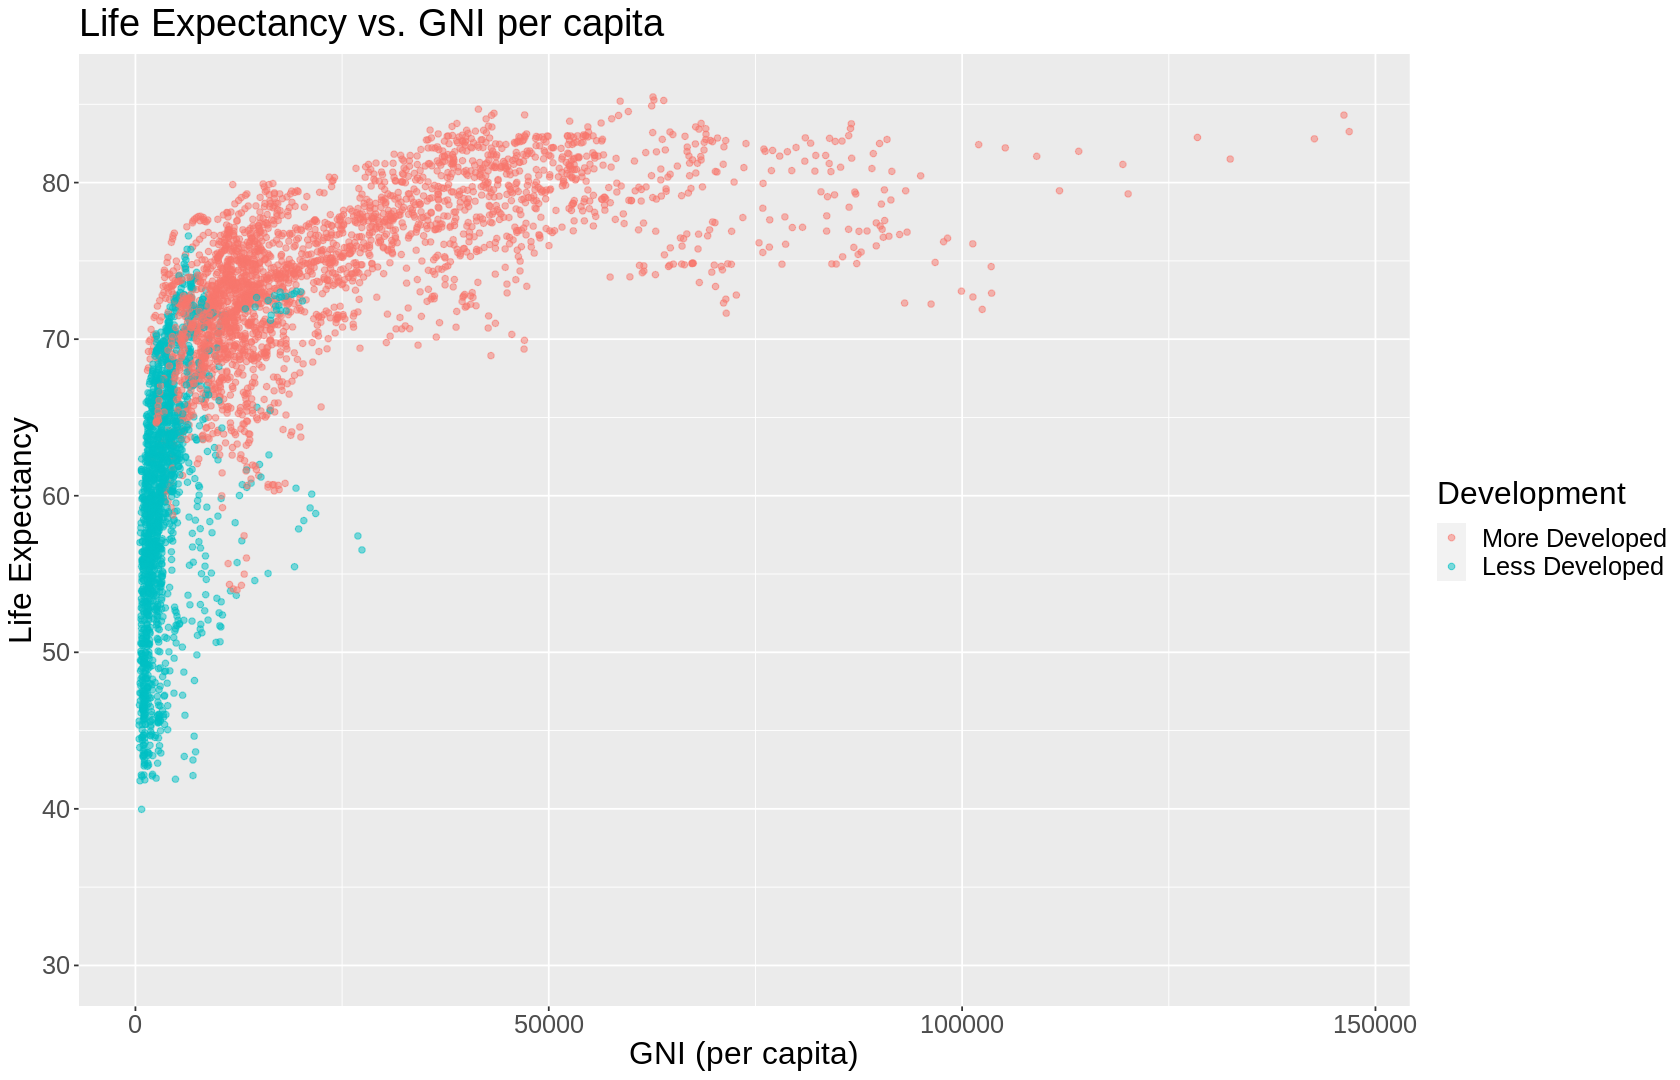

In [21]:
options(repr.plot.width = 14, repr.plot.height = 9)
gni_plot + ggtitle("Life Expectancy vs. GNI per capita")

#### Plot life expectancy against poverty rate:

Warning message:
“Removed 3263 rows containing missing values (geom_point).”


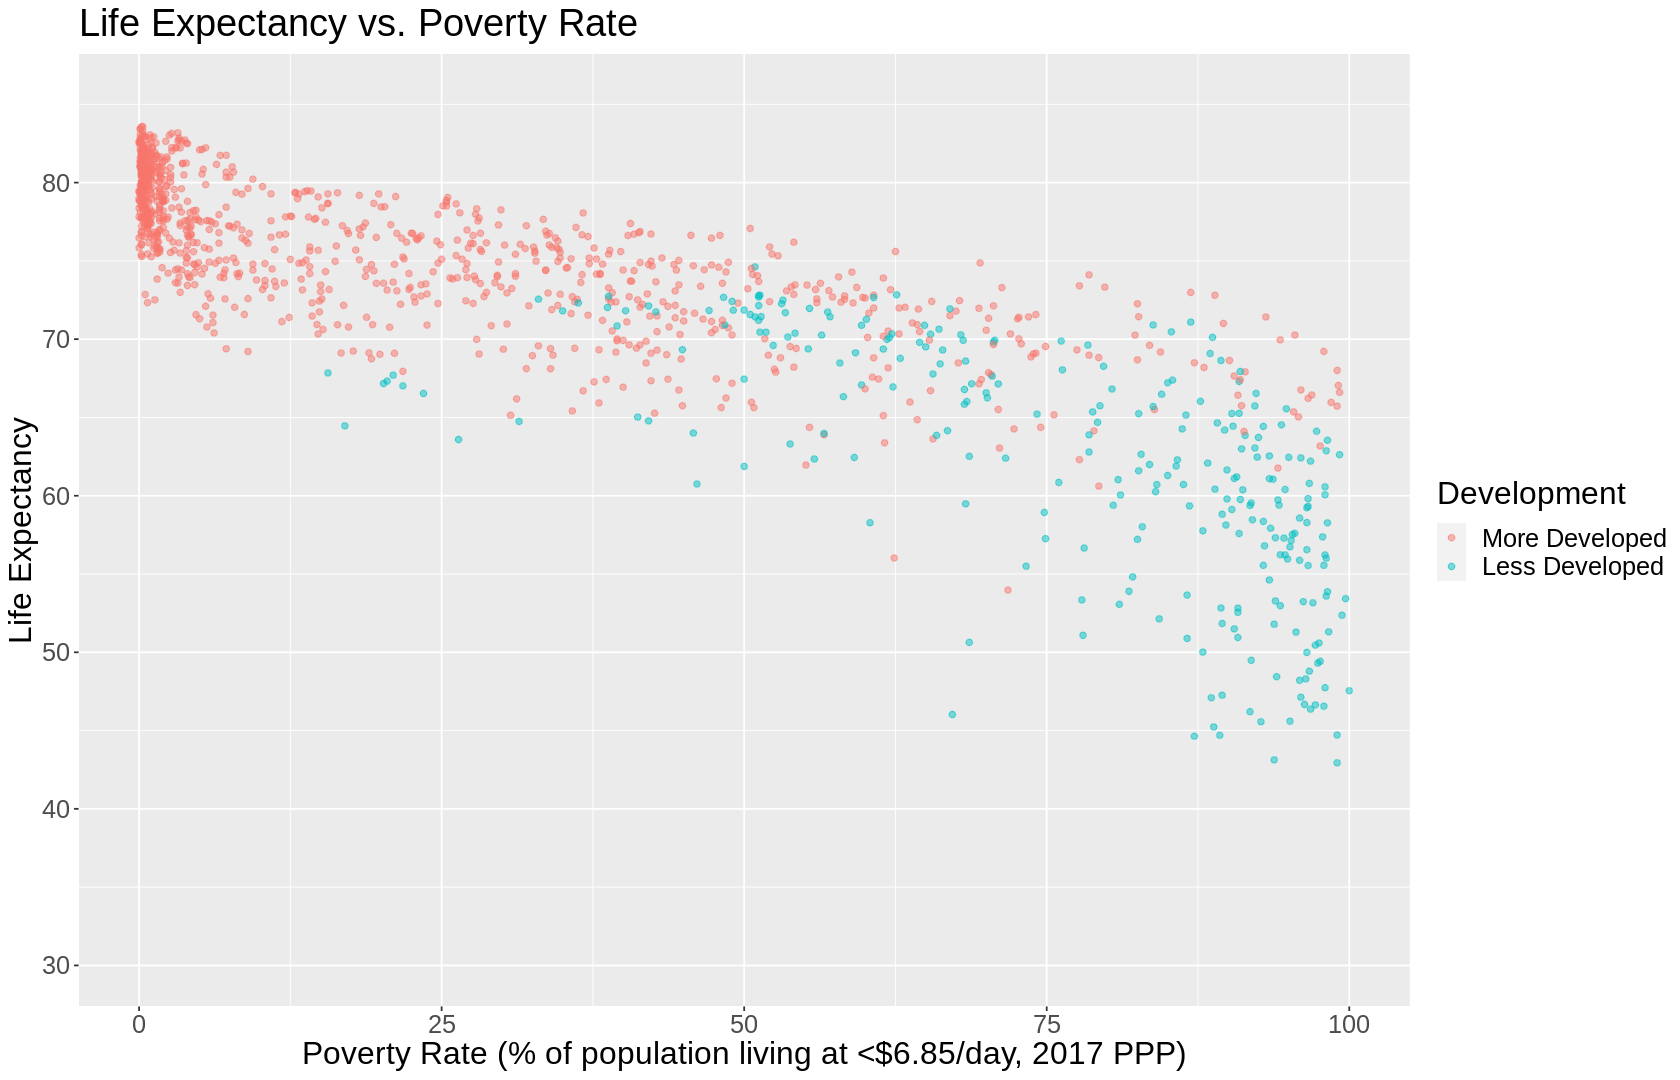

In [23]:
options(repr.plot.width = 14, repr.plot.height = 9)
poverty_plot + ggtitle("Life Expectancy vs. Poverty Rate")

#### Plot life expectancy against the mean years of schooling:

Warning message:
“Removed 322 rows containing missing values (geom_point).”


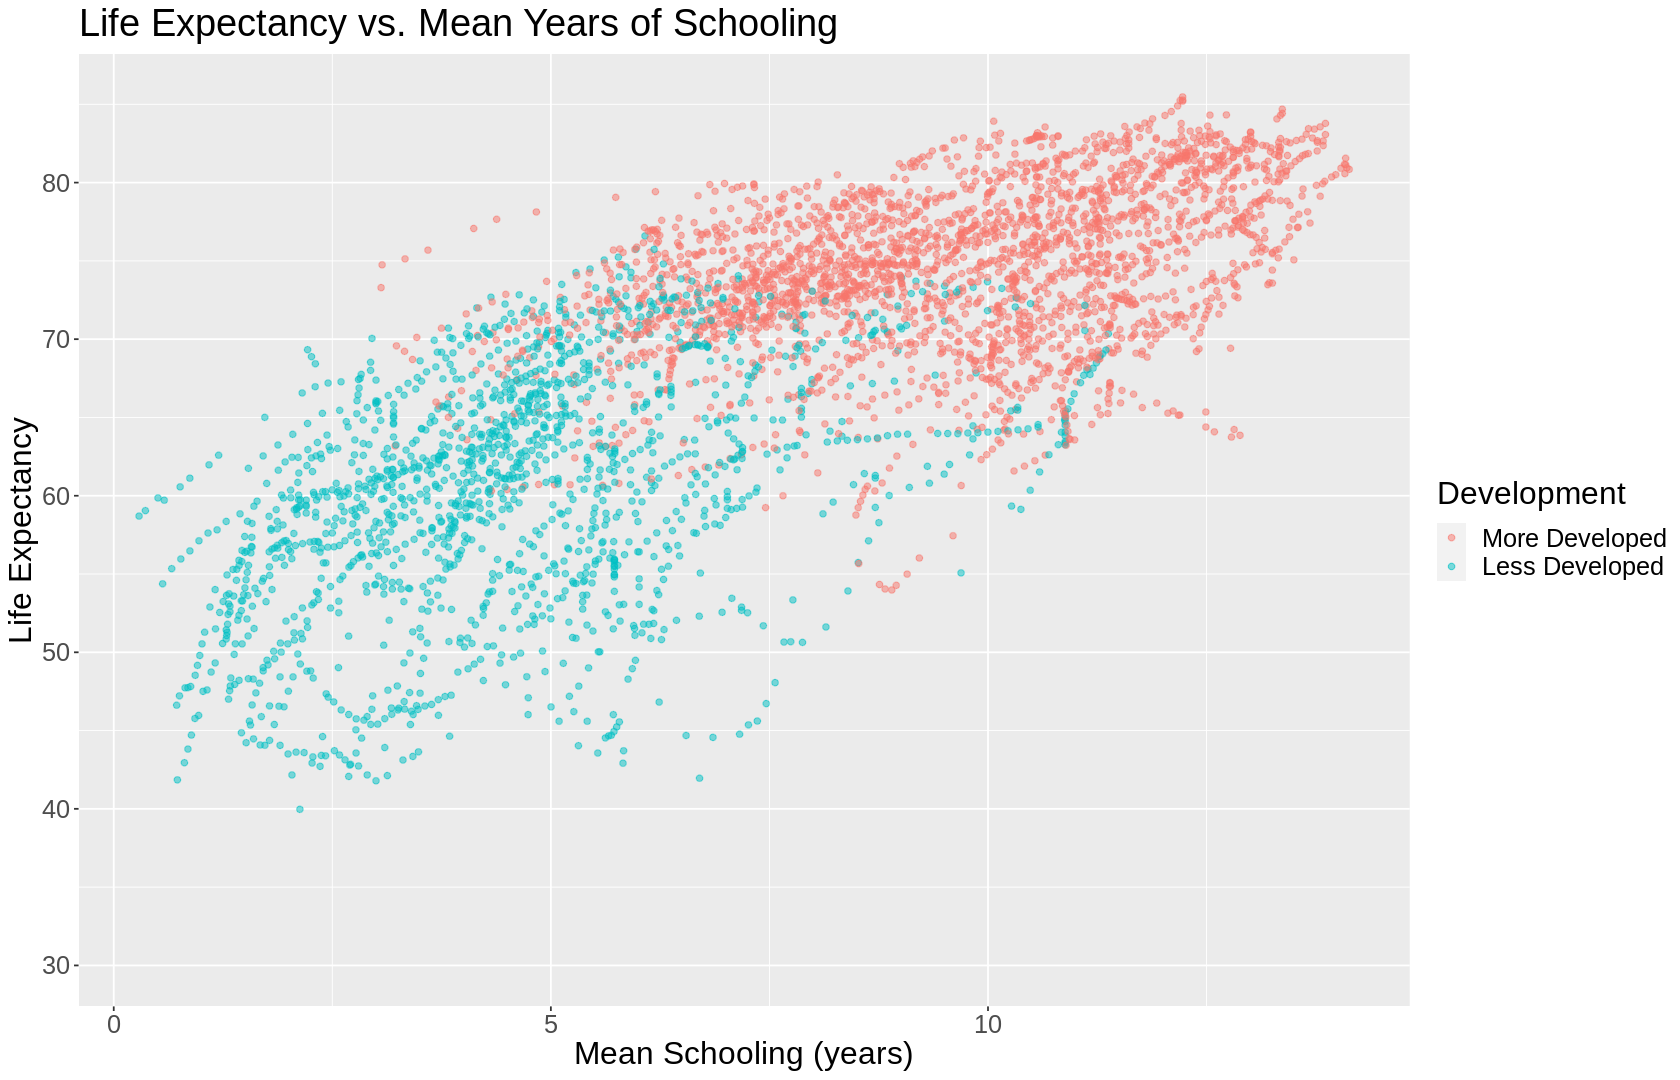

In [24]:
options(repr.plot.width = 14, repr.plot.height = 9)
schooling_plot + ggtitle("Life Expectancy vs. Mean Years of Schooling")

#### Plot life expectancy against CO<sub>2</sub> emissions (tonnes per capita):

Warning message:
“Removed 40 rows containing missing values (geom_point).”


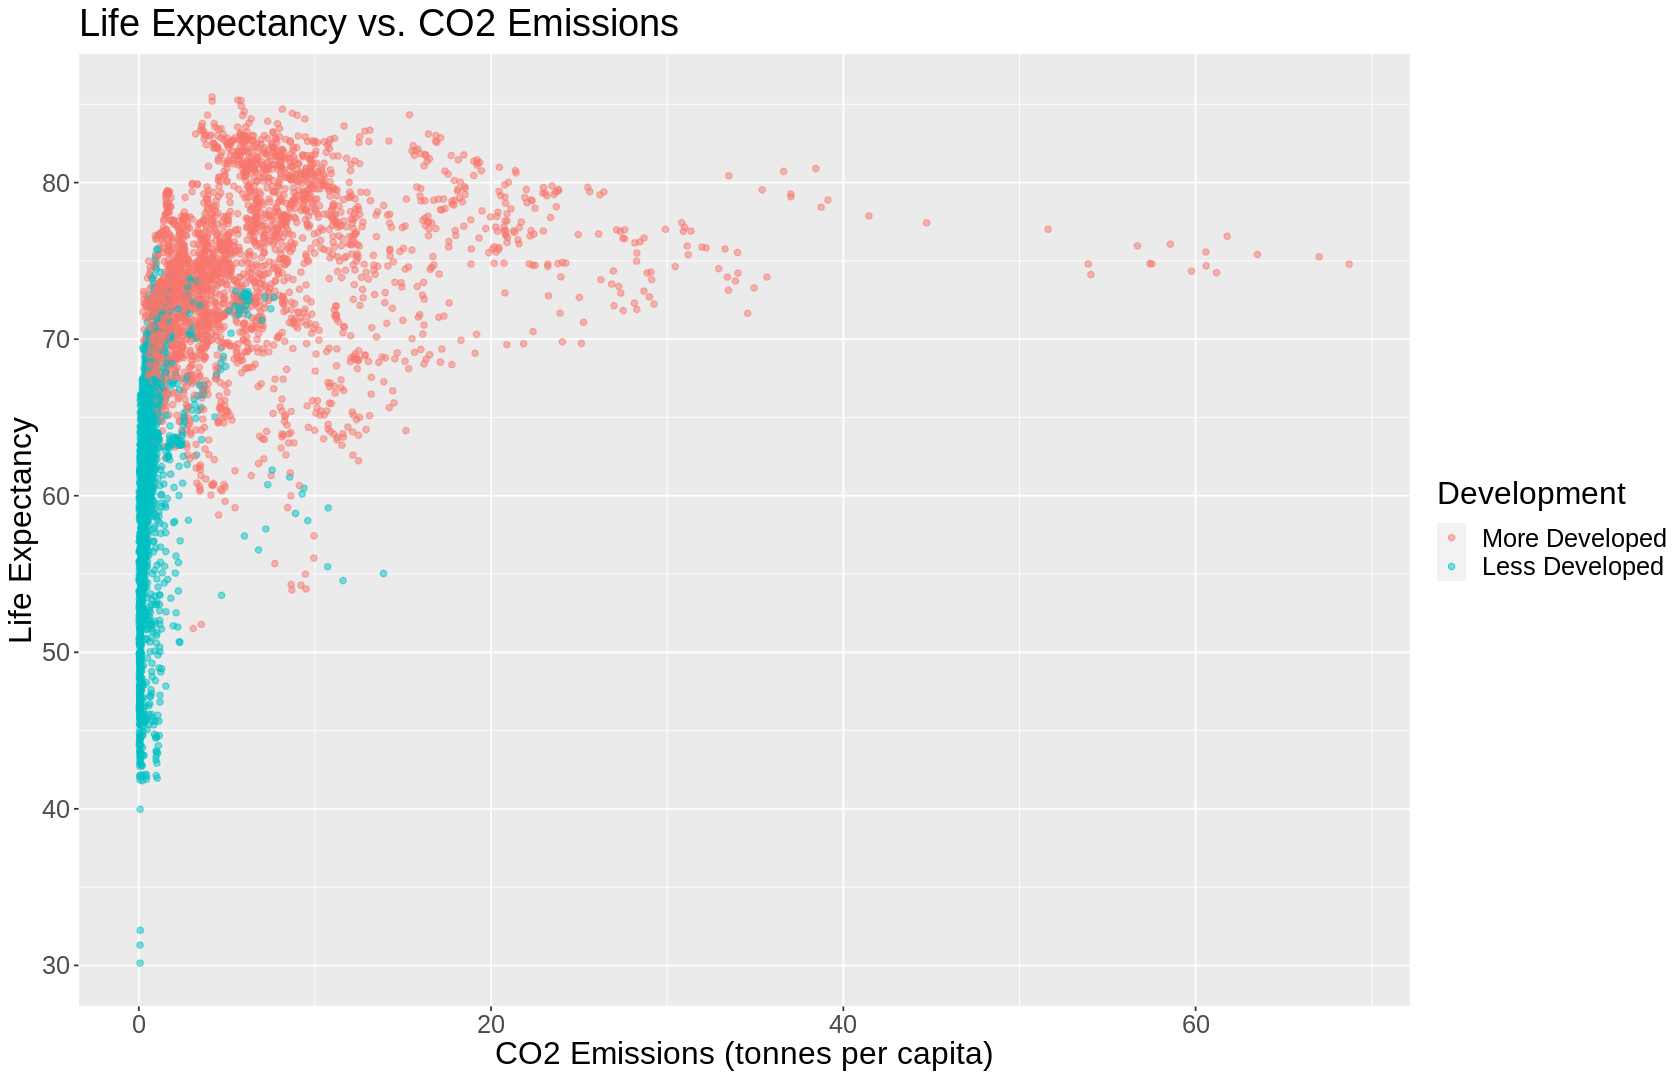

In [25]:
options(repr.plot.width = 14, repr.plot.height = 9)
co2_plot + ggtitle("Life Expectancy vs. CO2 Emissions")

#### All plots, side-by-side:

This view allows for easier comparison between relationship strengths than with separate plots, but requires the plots be much smaller.

In [31]:
options(repr.plot.width = 30, repr.plot.height = 6)

## Significance of Results

The main impact of these findings is to identify socioeconomic factors that contribute to life expectancy at birth, and also guide questions on how humanitarian efforts may target specific factors such as education that would have the greatest impact on extending life expectancy in less developed countries. In addition, our findings may inform other avenues of research, such as how the model for the social cost of carbon could be improved by including life expectancy as a factor.

## References

Blackburn, K., & Cipriani, G.P. (2002). A model of longevity, fertility and growth. <i>Journal of Economic Dynamics and Control, 26,</i> 187-204.

Hill, T. D., Jorgenson, A. K., Ore, P., Balistreri, K. S., & Clark, B. (2018). Air quality and life expectancy in the United States: An analysis of the moderating effect of income inequality. <i>SSM - population health, 7,</i> 100346. https://doi.org/10.1016/j.ssmph.2018.100346

Roser, M., Ortiz-Ospina, E., & Ritchie, H. (2013). <i>Life Expectancy</i>. Retrieved from https://ourworldindata.org/life-expectancy

World Health Organization. (2020). <i>GHE: Life expectancy and healthy life expectancy</i>. Retrieved from https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates/ghe-life-expectancy-and-healthy-life-expectancy